In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [12]:
data = pd.read_csv("kc_house_data.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [13]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [14]:
# 將date日期拆為年、月和日並轉成數值
# 將 'date' 欄位中的年份提取出來，轉換為數值型態，並存儲在新的 'year' 欄位中
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))

# 將 'date' 欄位中的月份提取出來，轉換為數值型態，並存儲在新的 'month' 欄位中
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))

# 將 'date' 欄位中的日期提取出來，轉換為數值型態，並存儲在新的 'day' 欄位中
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除 'id' 欄位，因為它對於分析沒有實際意義
# axis="columns" 表示刪除列，inplace=True 表示直接在原數據上進行修改
data.drop(['id'], axis="columns", inplace=True)

# 刪除原始的 'date' 欄位，因為我們已經將其拆分為年、月、日
# 同樣使用 axis="columns" 和 inplace=True
data.drop(['date'], axis="columns", inplace=True)

# 顯示處理後的數據集的前五行，以檢查我們的操作是否正確
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [15]:
# 獲取數據集的總樣本數
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
# 使用numpy的random.permutation函數生成一個隨機排列的索引數組
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
# 取前60%的索引作為訓練集
train_indexes = indexes[:int(data_num *0.6)]
# 取60%到80%的索引作為驗證集
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
# 取最後20%的索引作為測試集
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
# 使用loc函數根據索引從原始數據中提取對應的子集
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

In [16]:
# 將訓練資料和驗證資料合併為一個新的資料集
train_validation_data = pd.concat([train_data, val_data])

# 計算合併後資料集的平均值
mean = train_validation_data.mean()

# 計算合併後資料集的標準差
std = train_validation_data.std()

# 對訓練資料進行標準化處理：減去平均值後除以標準差
train_data = (train_data - mean) / std

# 對驗證資料進行標準化處理：使用與訓練資料相同的平均值和標準差
val_data = (val_data - mean) / std

In [17]:
# 將訓練數據中除了'price'列之外的所有特徵轉換為NumPy數組，作為輸入特徵x_train
x_train = np.array(train_data.drop('price', axis='columns'))

# 將訓練數據中的'price'列轉換為NumPy數組，作為目標變量y_train
y_train = np.array(train_data['price'])

# 將驗證數據中除了'price'列之外的所有特徵轉換為NumPy數組，作為輸入特徵x_val
x_val = np.array(val_data.drop('price', axis='columns'))

# 將驗證數據中的'price'列轉換為NumPy數組，作為目標變量y_val
y_val = np.array(val_data['price'])

In [18]:
# 建立一個Sequential型態的model（創建一個順序模型）
model = keras.Sequential(name='model-1')

# 第1層全連接層設為64個unit，將輸入形狀設定為(21, )，而實際上我們輸入的數據形狀為(batch_size, 21)
# （添加第一個密集層，有64個神經元，使用ReLU激活函數，輸入形狀為21維）
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))

# 第2層全連接層設為64個unit（添加第二個密集層，同樣有64個神經元，使用ReLU激活函數）
model.add(layers.Dense(64, activation='relu'))

# 最後一層全連接層設為1個unit（添加輸出層，只有1個神經元，用於回歸預測）
model.add(layers.Dense(1))

# 顯示網路模型架構（打印模型摘要，顯示每層的詳細信息）
model.summary()

Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1408      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [20]:
model_dir = 'lab2-logs/models/'
os.makedirs(model_dir)

FileExistsError: [WinError 183] 當檔案已存在時，無法建立該檔案。: 'lab2-logs/models/'

In [16]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                        monitor='val_mean_absolute_error', 
                                        save_best_only=True, 
                                        mode='min')

In [17]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=300,  # 整個dataset訓練300遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/300
203/203 [==============================] - 1s 2ms/step - loss: 0.3632 - mean_absolute_error: 0.3617 - val_loss: 0.2306 - val_mean_absolute_error: 0.3048
Epoch 2/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2128 - mean_absolute_error: 0.2846 - val_loss: 0.1970 - val_mean_absolute_error: 0.2787
Epoch 3/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1807 - mean_absolute_error: 0.2608 - val_loss: 0.2052 - val_mean_absolute_error: 0.2754
Epoch 4/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1622 - mean_absolute_error: 0.2474 - val_loss: 0.1627 - val_mean_absolute_error: 0.2494
Epoch 5/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1505 - mean_absolute_error: 0.2381 - val_loss: 0.1609 - val_mean_absolute_error: 0.2444
Epoch 6/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1374 - mean_absolute_error: 0.2282 - val_loss: 0.1497 - val_mean_absolute_error: 0.2409
Epoch 7/30

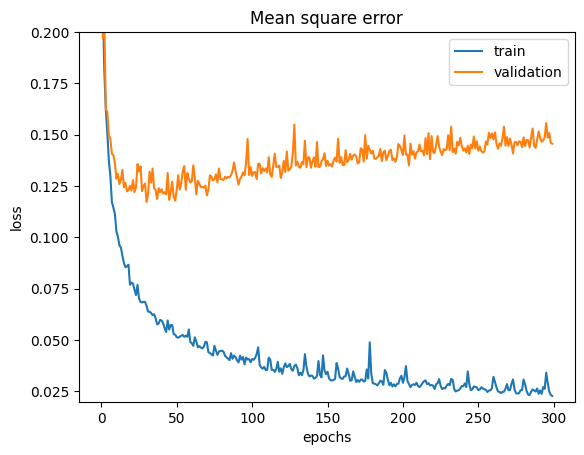

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

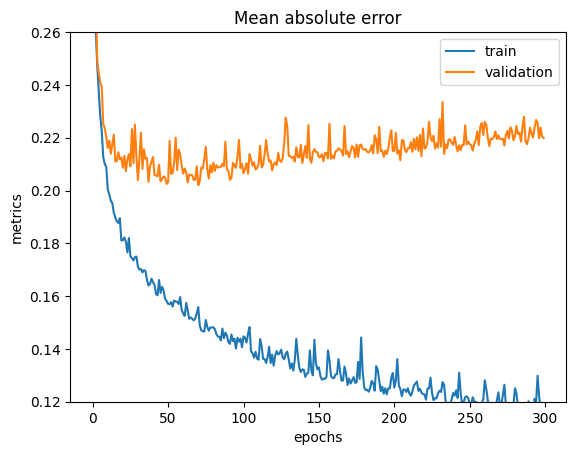

In [19]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [20]:
# 載入模型
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

136/136 [==============================] - 0s 816us/step
Model_1 Percentage Error: 13.89%


In [21]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard
%load_ext tensorboard

In [22]:
%tensorboard --port 9530 --logdir lab2-logs

In [23]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 1ms/step - loss: 0.4727 - mean_absolute_error: 0.4322 - val_loss: 0.2926 - val_mean_absolute_error: 0.3455
Epoch 2/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2819 - mean_absolute_error: 0.3239 - val_loss: 0.2526 - val_mean_absolute_error: 0.3205
Epoch 3/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2430 - mean_absolute_error: 0.3034 - val_loss: 0.2316 - val_mean_absolute_error: 0.3037
Epoch 4/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2228 - mean_absolute_error: 0.2910 - val_loss: 0.2173 - val_mean_absolute_error: 0.2908
Epoch 5/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2073 - mean_absolute_error: 0.2803 - val_loss: 0.2093 - val_mean_absolute_error: 0.2857
Epoch 6/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1943 - mean_absolute_error: 0.2727 - val_loss: 0.2003 - val_mean_absolute_error: 0.2754
Epoch 7/30

L! L2

In [24]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 2ms/step - loss: 0.4457 - mean_absolute_error: 0.3545 - val_loss: 0.3174 - val_mean_absolute_error: 0.3058
Epoch 2/300
203/203 [==============================] - 0s 1ms/step - loss: 0.3036 - mean_absolute_error: 0.2864 - val_loss: 0.2795 - val_mean_absolute_error: 0.2850
Epoch 3/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2635 - mean_absolute_error: 0.2683 - val_loss: 0.2553 - val_mean_absolute_error: 0.2621
Epoch 4/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2438 - mean_absolute_error: 0.2572 - val_loss: 0.2971 - val_mean_absolute_error: 0.2878
Epoch 5/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2332 - mean_absolute_error: 0.2497 - val_loss: 0.2251 - val_mean_absolute_error: 0.2454
Epoch 6/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2147 - mean_absolute_error: 0.2354 - val_loss: 0.2138 - val_mean_absolute_error: 0.2377
Epoch 7/30